<h1 style="text-align: center; color: blue;">Milestone 2: Task 3</h1>
<p style="text-align: center;">Finally, the moment of truth has arrived. We have created our several thousand timesteps of our HIV models, noted the final states of each simulation run, and extracted dozens of image features every 5 timesteps up until t=200. We took all of this information and collected into one CSV file called <i>data.csv</i></p>
<p style="text-align: center;">Let's get to creating some regressors (namely the <b>support vector machine, decision tree regressor, and gaussian processes regressor</b>)!</p>  

## Part 1: Getting a handle on the data

A lot of what we need to do in this task is running hundreds of different regression models. Basically, we need to run each of our three regressors with progressively more information from each timestep. At t=0, we will only be given the information from t=0 (which will be 300 runs' worth of data for <i>each of the three sizes</i>). 
<br>
If we instead look at t=120, we would have all the information from t=0, 5, 10, ..., 200 <i>(since we only collected information every 5 timesteps up until <b>t = 200</b>)</i>. 
<br>
This results in a slighty unique problem: we need to create MANY temporary dataframes within the function runs to be able to progressively add data to them and create the regressors. That is what this first part will be about. 

### Let's get into it!

In [2]:
# imports that are critical for any pandas work
import pandas as pd
import numpy as np

file_name = "data.csv"
all_simulation_data = pd.read_csv(file_name)
# since this is the Dos Santos model, let's collect split into just the Dos Santos rows
dos_santos = all_simulation_data[all_simulation_data["Model"] == "Dos Santos"]
dos_santos.head(10)

Model  Run    L  CELL_H  CELL_N  CELL_A1  CELL_A2  CELL_D  \
2700  Dos Santos    1  800   91104       0   365772    91328   91796   
2701  Dos Santos    2  800   91483       0   364486    91816   92215   
2702  Dos Santos    3  800   91183       0   363962    92147   92708   
2703  Dos Santos    4  800   91516       0   365560    90938   91986   
2704  Dos Santos    5  800   91157       0   364103    92287   92453   
2705  Dos Santos    6  800   91275       0   365199    91403   92123   
2706  Dos Santos    7  800   91686       0   364868    91196   92250   
2707  Dos Santos    8  800   91537       0   365148    91248   92067   
2708  Dos Santos    9  800   91355       0   364169    91844   92632   
2709  Dos Santos   10  800   91010       0   366008    91087   91895   

      T=0_10_num_blobs  T=0_10_avg_blob_dist  ...  T=200_avg_perim_20  \
2700                 4            418.133130  ...           94.750691   
2701                 1              0.000000  ...           89.295083   
2702                 3            428.985355  ...           68.849914   
2703                 3            191.420664  ...          191.221590   
2704                 4            399.463737  ...           75.278358   
2705                 0              0.000000  ...           83.017061   
2706                 1              0.000000  ...          540.830994   
2707                 4            508.951710  ...          207.425461   
2708                 1              0.000000  ...           77.262186   
2709                 2            188.141184  ...          133.034418   

      T=200_max_cnt_area  T=200_max_cnt_perim  T=200_numofLogBlob  \
2700            137463.0          8955.092489                 197   
2701            118440.0          7332.163556                 183   
2702             70855.5          2574.541192                  71   
2703             83677.0          4802.509666                  95   
2704             67652.0          5011.251869                 133   
2705            103640.0          3634.641697                 152   
2706             56918.0          3204.083260                 122   
2707            122867.5          4485.882250                 122   
2708             90361.5          4063.771640                 150   
2709             56541.5          5780.651802                 129   

      T=200_AvgSizeofLogblob  T=200_blob_varx  T=200_blob_vary  \
2700               12.470389       311.385985       219.276572   
2701               12.489375       383.465160       253.342994   
2702               15.383412       738.374032      1435.288728   
2703               11.473684       479.571767       465.269729   
2704               12.723475       568.647412       327.953868   
2705               11.973684       340.956740       448.001066   
2706               10.637523       446.939808       497.343201   
2707               12.786885       606.842382       423.685240   
2708               12.281481       453.462371       340.769431   
2709               11.205857       458.597175       367.387342   

      T=200_Num Corners  T=200_Avg Manhatten Dist Between Corners  \
2700               1577                                493.972684   
2701               1631                                486.990010   
2702               1494                                565.067441   
2703                253                                372.634848   
2704               1310                                540.615782   
2705               1322                                469.693799   
2706                 88                                431.571281   
2707                257                                364.361247   
2708               1332                                461.925069   
2709                452                                282.678469   

      T=200_Avg Euclidean Dist Between Corners  
2700                                404.417690  
2701                                392.240656  
2702                

In [3]:
# we can also drop the first three columns, since they simply label the different sizes, runs, and that these are all Dos Santos models
dos_santos = dos_santos.drop(['Model','Run','L','CELL_N'], axis=1)

It's important to know what the actual columns of data _include_ so we know what columns of data there are. Here is a full list of all of the different image features that we pulled at each timestep:

In [4]:
# these are the generic feature names without worrying about timesteps
names = ["10_num_blobs", "10_avg_blob_dist", "10_avg_blob_size", "cnt_area_10", "cnt_area_100", 
                         "cnt_perim_10", "cnt_perim_20", "avg_area_10", "avg_area_100", "avg_perim_10", 
                         "avg_perim_20", "max_cnt_area", "max_cnt_perim", "numofLogBlob", "AvgSizeofLogblob", 
                         "blob_varx", "blob_vary", "Num Corners", "Avg Manhatten Dist Between Corners", 
                         "Avg Euclidean Dist Between Corners"]

To denote different timesteps, each feature was tagged with a "<b>T=#_</b><i>rest of feature name</i>"

### Let's split this data set into different timesteps!

In [ ]:
tempDF = pd.DataFrame(columns=None)

# the best way to do this is to take a smaller data frame and add onto it at each of the timesteps
for step in timesteps:
    for name in names:
        column_name = "T={}_{}".format(step, name)
        tempDF = pd.concat([tempDF, dos_santos[column_name]], axis=1)

Perfect! Now, we know how to load the data in progressively larger chunks in order to feed them into our regressors. Speaking of regressors....

## Part 2: Regressors
As mentioned above, we will be using some models we've already used in the past and some new models. 
1. __Decision Tree Regressor__ - I won't spend too much time discussing this since we already used it in Milestone 1. Seeing as there is no requirement in this milestone for hyperparameter tuning (as I assume we are trying to get a handle on how well each regressor functions on a given HIV model at a given time), we we will use a default Decision Tree Regressor from scikit-learn with a max depth of 4.
2. __Support Vector Machine__ - Upon reading Chapter 5 in the textbook, there are a few Support Vector Regressors that show promise for a dataset of this size. We will explore the viability of the linear, polynomial, and Gaussian Radial Basis Function (RBF). Given our large number of features and relatively small data , it is likely that the linear and rbf kernals will work the best, but it won't hurt to try our polynomial regressor with its _kernal trick_ as described in the book. The kernal trick allows for a smaller order polynomial function to act as a stand in for one of a higher order without losing accuracy of the support vector machine. Much of this next section will include some basic testing of these three different keransl at t=0, t=50, t=100, t=150, and t=200, and comparing their errors to see which kernal appears the most promising for our data.
3. __Gaussian Processes__ - Now, at first, we were reading the documentation for this regressor and asking ourselves the question, _"Why would Dr. Giabanelli assign us a model that can only handle data with a few dozen columns of data at most, knowing we will have potentially hundreds of columns?"_ We pondered this and realized that this particular would be very good early on, but then get progressively worse, and that is totally fine. Thus, we will also be looking at this one with the understanding that its performance depends entirely on the early time steps. For this, we will test 4 kernels: RBF (the default), ConstantKernel, Rational Quadratic, and Matern. These two are mainly chosen because many of the other kernels have specific uses (such as the ExpSineSquared Kernel applying well to periodic functions). These seem to be more general use kernels, and thus, we will test them as such.

### First, we will test the SVM's abilities
This will happen a t=0, t=50, t=100, t=150, and t=200

In [14]:
# these are the kernals we will test
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# all of these models will be overtuned, since trying to run these models has extended into hours before
svm_kernel_lin = Pipeline([("scaler", StandardScaler()), 
                           ("linear", SVR(kernel="linear", C=.001))])     # use this one because we have plenty of features!

svm_kernel_poly = Pipeline([("scaler", StandardScaler()), 
                            ("poly", SVR(kernel="poly", degree=3, C=.001))])

svm_kernel_rbf = Pipeline([("scaler", StandardScaler()), 
                           ("rbf", SVR(kernel="rbf", C=.001))])      # use this one because the training set isn't that large!

Let's run each model to predict the healthy, A1, A2, and dead cells.

In [15]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from math import sqrt

select_timesteps = [0,50,100,150,200]

# hold the errors for some plots
# index 0 list is CELL_H, 1 is CELL_A1, 2 is CELL_A2, and 3 is CELL_D
error_lin = [[],[],[],[]]
error_poly = [[],[],[],[]]
error_rbf = [[],[],[],[]]

for step in range(0,201,5):
    tempDF = dos_santos[["CELL_H","CELL_A1","CELL_A2","CELL_D"]].copy()
    for name in names:
        column_name = "T={}_{}".format(step, name)
        tempDF = pd.concat([tempDF, dos_santos[column_name]], axis=1)   
        
    if step in select_timesteps:
        for label in range(4):
            # separate the labels from the rest of the data
            train_set, test_set = train_test_split(tempDF, test_size=0.2, random_state=42) 
            if label == 0:   
                train_set_labels = train_set[["CELL_H"]].copy()
                test_set_labels = test_set[["CELL_H"]].copy()
            elif label == 1:
                train_set_labels = train_set[["CELL_A1"]].copy()
                test_set_labels = test_set[["CELL_A1"]].copy()
            elif label == 2:
                train_set_labels = train_set[["CELL_A2"]].copy()
                test_set_labels = test_set[["CELL_A2"]].copy()
            elif label == 3:
                train_set_labels = train_set[["CELL_D"]].copy()
                test_set_labels = test_set[["CELL_D"]].copy()
                
            train_set = train_set.drop(["CELL_H","CELL_A1", "CELL_A2", "CELL_D"], axis=1)
            test_set = test_set.drop(["CELL_H","CELL_A1", "CELL_A2", "CELL_D"], axis=1)
            
            # let's test the linear kernel first
            svm_kernel_lin.fit(train_set, train_set_labels)
            lin_predict = svm_kernel_lin.predict(test_set)
            lin_mse = mean_squared_error(lin_predict, test_set_labels)
            lin_rmse = sqrt(lin_mse)
            error_lin[label].append(lin_rmse)
            
            # next the poly kernel
            svm_kernel_poly.fit(train_set, train_set_labels)
            poly_predict = svm_kernel_poly.predict(test_set)
            poly_mse = mean_squared_error(poly_predict, test_set_labels)
            poly_rmse = sqrt(poly_mse)
            error_poly[label].append(poly_rmse)
            
            # finally the rbf kernel
            svm_kernel_rbf.fit(train_set, train_set_labels)
            rbf_predict = svm_kernel_rbf.predict(test_set)
            rbf_mse = mean_squared_error(rbf_predict, test_set_labels)
            rbf_rmse = sqrt(rbf_mse)
            error_rbf[label].append(rbf_rmse)

C:\Users\drran\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\drran\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\drran\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\drran\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Pleas

C:\Users\drran\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\drran\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\drran\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\drran\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), 

C:\Users\drran\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\drran\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\drran\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


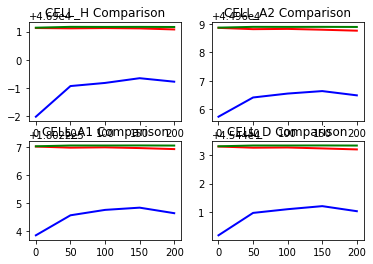

In [36]:
# let's plot these now
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

fig, ax = plt.subplots(2, 2)

# CELL_H subplot
ax[0,0].plot(select_timesteps, error_lin[0], marker='', color='blue', linewidth=2)
ax[0,0].plot(select_timesteps, error_poly[0], marker='', color='red', linewidth=2)
ax[0,0].plot(select_timesteps, error_rbf[0], marker='', color='green', linewidth=2)
ax[0,0].set_title("CELL_H Comparison")

# CELL_A1 subplot
ax[1,0].plot(select_timesteps, error_lin[1], marker='', color='blue', linewidth=2)
ax[1,0].plot(select_timesteps, error_poly[1], marker='', color='red', linewidth=2)
ax[1,0].plot(select_timesteps, error_rbf[1], marker='', color='green', linewidth=2)
ax[1,0].set_title("CELL_A1 Comparison")

# CELL_A2 subplot
ax[0,1].plot(select_timesteps, error_lin[2], marker='', color='blue', linewidth=2)
ax[0,1].plot(select_timesteps, error_poly[2], marker='', color='red', linewidth=2)
ax[0,1].plot(select_timesteps, error_rbf[2], marker='', color='green', linewidth=2)
ax[0,1].set_title("CELL_A2 Comparison")

# CELL_D subplot
ax[1,1].plot(select_timesteps, error_lin[3], marker='', color='blue', linewidth=2)
ax[1,1].plot(select_timesteps, error_poly[3], marker='', color='red', linewidth=2)
ax[1,1].plot(select_timesteps, error_rbf[3], marker='', color='green', linewidth=2)
ax[1,1].set_title("CELL_D Comparison")


plt.show()

So here are the results! The blue line _(which represents the Linear kernel)_ is a resounding winner!
<br>
<br>
Except that it's really not. Let's look at the actual values below:

In [17]:
print(error_lin)
print(error_poly)
print(error_rbf)

[[46897.98437295985, 46899.06992150243, 46899.18065081452, 46899.34828454408, 46899.22460942325], [180223.84791101835, 180224.5643315195, 180224.7578311413, 180224.83780898224, 180224.63982005365], [44965.74035709011, 44966.41638376962, 44966.554304759804, 44966.64142525234, 44966.49159215346], [45440.18509887774, 45440.97184905386, 45441.10202777975, 45441.20957119045, 45441.03160631365]]
[[46901.12572362812, 46901.11424304221, 46901.123896080164, 46901.11263603633, 46901.07518708852], [180227.02543129429, 180226.98545415018, 180226.9968645695, 180226.9706565928, 180226.93421082562], [44968.86521834768, 44968.819540856115, 44968.828519678, 44968.800156313315, 44968.76605251174], [45443.303610427756, 45443.26208174395, 45443.26921341974, 45443.236827617766, 45443.20177543456]]
[[46901.13734532834, 46901.16710120963, 46901.16433053846, 46901.165857573214, 46901.162579982236], [180227.03415037508, 180227.06283817082, 180227.0619809352, 180227.0643226391, 180227.060372295], [44968.8731572

The plots above have a scale such that any small differences appear very large, when in reality... they are negligably small, as you can see in the actual error data given above. Since the Linear one still does technically have the lowest error, we will use it, but at this point we have not conclusively found a difference beween them, just that one kernel happens to appear more promising than the others.

## Second, we will test the Gaussian Processes' Abilities
This will happen a t=0, 25, 50, 75, 100, 125, 150, 175, 200

In [59]:
# these are the kernals we will test
from sklearn.gaussian_process import GaussianProcessRegressor as gpr
import sklearn.gaussian_process.kernels as k

gpr_none = gpr(kernel=k.RBF())
gpr_matern = gpr(kernel=k.Matern(length_scale=1, nu=1.5))
gpr_con = gpr(kernel=k.ConstantKernel(constant_value=1, constant_value_bounds=(0.0,10.0)))
gpr_rq = gpr(kernel=k.RationalQuadratic(alpha=.1, length_scale=1))

In [64]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from math import sqrt
import time

# let's test how long these models take to create as well
start = time.time()

# we're going to try a lot more time steps to more accurately measure how these distributions work more closely
select_timesteps = [0,25,50,75,100,125,150,175,200]

# hold the errors for some plots
# index 0 list is CELL_H, 1 is CELL_A1, 2 is CELL_A2, and 3 is CELL_D
error_matern = [[],[],[],[]]
error_none = [[],[],[],[]]
error_con = [[],[],[],[]]
error_rq = [[],[],[],[]]

tempDF = dos_santos[["CELL_H","CELL_A1","CELL_A2","CELL_D"]].copy()

for step in range(0,201,5):
    for name in names:
        column_name = "T={}_{}".format(step, name)
        tempDF = pd.concat([tempDF, dos_santos[column_name]], axis=1)
        
    if step in select_timesteps:
        for label in range(4):
            train_set, test_set = train_test_split(tempDF, test_size=0.2, random_state=42)
            
            # separate the labels from the rest of the data
            if label == 0:   
                train_set_labels = train_set[["CELL_H"]].copy()
                test_set_labels = test_set[["CELL_H"]].copy()
            elif label == 1:
                train_set_labels = train_set[["CELL_A1"]].copy()
                test_set_labels = test_set[["CELL_A1"]].copy()
            elif label == 2:
                train_set_labels = train_set[["CELL_A2"]].copy()
                test_set_labels = test_set[["CELL_A2"]].copy()
            elif label == 3:
                train_set_labels = train_set[["CELL_D"]].copy()
                test_set_labels = test_set[["CELL_D"]].copy()
                
            train_set = train_set.drop(["CELL_H","CELL_A1", "CELL_A2", "CELL_D"], axis=1)
            test_set = test_set.drop(["CELL_H","CELL_A1", "CELL_A2", "CELL_D"], axis=1)
            
            # let's test the no kernel first
            gpr_none.fit(train_set, train_set_labels)
            gpr_none_predict = gpr_none.predict(test_set)
            gpr_none_mse = mean_squared_error(gpr_none_predict, test_set_labels)
            gpr_none_rmse = sqrt(gpr_none_mse)
            error_none[label].append(gpr_none_rmse)
            
            # next the Matern kernel
            gpr_matern.fit(train_set, train_set_labels)
            matern_predict = gpr_matern.predict(test_set)
            matern_mse = mean_squared_error(matern_predict, test_set_labels)
            matern_rmse = sqrt(matern_mse)
            error_matern[label].append(matern_rmse)
            
            # constant kernel
            gpr_con.fit(train_set, train_set_labels)
            con_predict = gpr_con.predict(test_set)
            con_mse = mean_squared_error(con_predict, test_set_labels)
            con_rmse = sqrt(con_mse)
            error_con[label].append(con_rmse)
            
            # rational quadratic kernel
            gpr_rq.fit(train_set, train_set_labels)
            rq_predict = gpr_rq.predict(test_set)
            rq_mse = mean_squared_error(rq_predict, test_set_labels)
            rq_rmse = sqrt(rq_mse)
            error_rq[label].append(rq_rmse)
            
        print(step)
        
end = time.time()

print("{} seconds passed".format(end-start))

C:\Users\drran\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:290: RuntimeWarning: divide by zero encountered in log
  return np.log(np.vstack(bounds))
C:\Users\drran\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:290: RuntimeWarning: divide by zero encountered in log
  return np.log(np.vstack(bounds))
C:\Users\drran\Anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-2.18874942e+18]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 21, 'nit': 0, 'warnflag': 2}
  ConvergenceWarning)
C:\Users\drran\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:290: RuntimeWarning: divide by zero encountered in log
  return np.log(np.vstack(bounds))
C:\Users\drran\Anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-1.32293239e+17]), 'task': b'A

0


C:\Users\drran\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:290: RuntimeWarning: divide by zero encountered in log
  return np.log(np.vstack(bounds))
C:\Users\drran\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:290: RuntimeWarning: divide by zero encountered in log
  return np.log(np.vstack(bounds))
C:\Users\drran\Anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-2.18874942e+18]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 21, 'nit': 0, 'warnflag': 2}
  ConvergenceWarning)
C:\Users\drran\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:290: RuntimeWarning: divide by zero encountered in log
  return np.log(np.vstack(bounds))
C:\Users\drran\Anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-1.32293239e+17]), 'task': b'A

25


C:\Users\drran\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:290: RuntimeWarning: divide by zero encountered in log
  return np.log(np.vstack(bounds))
C:\Users\drran\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:290: RuntimeWarning: divide by zero encountered in log
  return np.log(np.vstack(bounds))
C:\Users\drran\Anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-2.18874942e+18]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 21, 'nit': 0, 'warnflag': 2}
  ConvergenceWarning)
C:\Users\drran\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:290: RuntimeWarning: divide by zero encountered in log
  return np.log(np.vstack(bounds))
C:\Users\drran\Anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-1.32293239e+17]), 'task': b'A

50


C:\Users\drran\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:290: RuntimeWarning: divide by zero encountered in log
  return np.log(np.vstack(bounds))
C:\Users\drran\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:290: RuntimeWarning: divide by zero encountered in log
  return np.log(np.vstack(bounds))
C:\Users\drran\Anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-2.18874942e+18]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 21, 'nit': 0, 'warnflag': 2}
  ConvergenceWarning)
C:\Users\drran\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:290: RuntimeWarning: divide by zero encountered in log
  return np.log(np.vstack(bounds))
C:\Users\drran\Anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-1.32293239e+17]), 'task': b'A

75


C:\Users\drran\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:290: RuntimeWarning: divide by zero encountered in log
  return np.log(np.vstack(bounds))
C:\Users\drran\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:290: RuntimeWarning: divide by zero encountered in log
  return np.log(np.vstack(bounds))
C:\Users\drran\Anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-2.18874942e+18]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 21, 'nit': 0, 'warnflag': 2}
  ConvergenceWarning)
C:\Users\drran\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:290: RuntimeWarning: divide by zero encountered in log
  return np.log(np.vstack(bounds))
C:\Users\drran\Anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-1.32293239e+17]), 'task': b'A

100


C:\Users\drran\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:290: RuntimeWarning: divide by zero encountered in log
  return np.log(np.vstack(bounds))
C:\Users\drran\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:290: RuntimeWarning: divide by zero encountered in log
  return np.log(np.vstack(bounds))
C:\Users\drran\Anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-2.18874942e+18]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 21, 'nit': 0, 'warnflag': 2}
  ConvergenceWarning)
C:\Users\drran\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:290: RuntimeWarning: divide by zero encountered in log
  return np.log(np.vstack(bounds))
C:\Users\drran\Anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-1.32293239e+17]), 'task': b'A

125


C:\Users\drran\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:290: RuntimeWarning: divide by zero encountered in log
  return np.log(np.vstack(bounds))
C:\Users\drran\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:290: RuntimeWarning: divide by zero encountered in log
  return np.log(np.vstack(bounds))
C:\Users\drran\Anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-2.18874942e+18]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 21, 'nit': 0, 'warnflag': 2}
  ConvergenceWarning)
C:\Users\drran\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:290: RuntimeWarning: divide by zero encountered in log
  return np.log(np.vstack(bounds))
C:\Users\drran\Anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-1.32293239e+17]), 'task': b'A

150


C:\Users\drran\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:290: RuntimeWarning: divide by zero encountered in log
  return np.log(np.vstack(bounds))
C:\Users\drran\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:290: RuntimeWarning: divide by zero encountered in log
  return np.log(np.vstack(bounds))
C:\Users\drran\Anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-2.18874942e+18]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 21, 'nit': 0, 'warnflag': 2}
  ConvergenceWarning)
C:\Users\drran\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:290: RuntimeWarning: divide by zero encountered in log
  return np.log(np.vstack(bounds))
C:\Users\drran\Anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-1.32293239e+17]), 'task': b'A

175


C:\Users\drran\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:290: RuntimeWarning: divide by zero encountered in log
  return np.log(np.vstack(bounds))
C:\Users\drran\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:290: RuntimeWarning: divide by zero encountered in log
  return np.log(np.vstack(bounds))
C:\Users\drran\Anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-2.18874942e+18]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 21, 'nit': 0, 'warnflag': 2}
  ConvergenceWarning)
C:\Users\drran\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:290: RuntimeWarning: divide by zero encountered in log
  return np.log(np.vstack(bounds))
C:\Users\drran\Anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-1.32293239e+17]), 'task': b'A

200
234.87081146240234 seconds passed


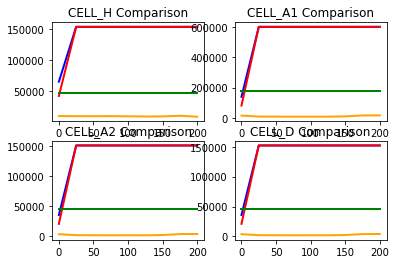

In [65]:
# let's plot these now
import matplotlib.pyplot as plt
%matplotlib inline

fig, axs = plt.subplots(2, 2)

# CELL_H subplot
axs[0,0].plot(select_timesteps, error_none[0], marker='', color='blue', linewidth=2)
axs[0,0].plot(select_timesteps, error_matern[0], marker='', color='red', linewidth=2)
axs[0,0].plot(select_timesteps, error_con[0], marker='', color='green', linewidth=2)
axs[0,0].plot(select_timesteps, error_rq[0], marker='', color='orange', linewidth=2)
axs[0,0].set_title("CELL_H Comparison")

# CELL_A1 subplot
axs[0,1].plot(select_timesteps, error_none[1], marker='', color='blue', linewidth=2)
axs[0,1].plot(select_timesteps, error_matern[1], marker='', color='red', linewidth=2)
axs[0,1].plot(select_timesteps, error_con[1], marker='', color='green', linewidth=2)
axs[0,1].plot(select_timesteps, error_rq[1], marker='', color='orange', linewidth=2)
axs[0,1].set_title("CELL_A1 Comparison")

# CELL_A2 subplot
axs[1,0].plot(select_timesteps, error_none[2], marker='', color='blue', linewidth=2)
axs[1,0].plot(select_timesteps, error_matern[2], marker='', color='red', linewidth=2)
axs[1,0].plot(select_timesteps, error_con[2], marker='', color='green', linewidth=2)
axs[1,0].plot(select_timesteps, error_rq[2], marker='', color='orange', linewidth=2)
axs[1,0].set_title("CELL_A2 Comparison")

# CELL_D subplot
axs[1,1].plot(select_timesteps, error_none[3], marker='', color='blue', linewidth=2)
axs[1,1].plot(select_timesteps, error_matern[3], marker='', color='red', linewidth=2)
axs[1,1].plot(select_timesteps, error_con[3], marker='', color='green', linewidth=2)
axs[1,1].plot(select_timesteps, error_rq[3], marker='', color='orange', linewidth=2)
axs[1,1].set_title("CELL_D Comparison")


plt.show()

Once again, let's try to look past the Matern kernel jumping up in value extremely quickly as well as the Constant kernel performing, well, constantly. Let's look at the actual values.

In [67]:
print(error_none, end='\n\n\n')
print(error_matern, end='\n\n\n')
print(error_con, end='\n\n\n')
print(error_rq, end='\n\n\n')

[[64933.13676747526, 153021.16728891173, 153021.16728891173, 153021.16728891173, 153021.16728891173, 153021.16728891173, 153021.16728891173, 153021.16728891173, 153021.16728891173], [139177.82629000244, 602502.3962482869, 602502.3962482869, 602502.3962482869, 602502.3962482869, 602502.3962482869, 602502.3962482869, 602502.3962482869, 602502.3962482869], [35489.274982054376, 150607.27723346496, 150607.27723346496, 150607.27723346496, 150607.27723346496, 150607.27723346496, 150607.27723346496, 150607.27723346496, 150607.27723346496], [35905.66884335437, 152140.5729703436, 152140.5729703436, 152140.5729703436, 152140.5729703436, 152140.5729703436, 152140.5729703436, 152140.5729703436, 152140.5729703436]]


[[41925.31577875036, 153021.16728891173, 153021.16728891173, 153021.16728891173, 153021.16728891173, 153021.16728891173, 153021.16728891173, 153021.16728891173, 153021.16728891173], [80736.5688342377, 602502.3962482869, 602502.3962482869, 602502.3962482869, 602502.3962482869, 602502.396

This tells us the real story. There appear to be a divergence in how the kernels react. Some of the kernels (namely the _Matern_ and <i>RBF</i>) act as they are described in the documentation: very good with few features, but progressively worse as more features are added. <br><br>

However, there appears to be a big difference between these kernels and the other family of kernels (_Constant_ and <i>Rational Quadratic</i>) seem to have relatively constant error. In terms of the ConstantKernel, it actually __does__ have a constant error.<br><br>

This leave us with a predicament: do we go with the one that appears to have extremely low error (could be overfitting) or the one that appears to follow the documentations' description?

## Part 3: Conclusions
Based upon testing, our three regressors we should use are:
1. Decision Tree Regressor
2. Support Vector Machine with Linear Kernel
3. Gaussian Processes with Matern Kernel or Rational Quadratic Kernel, depending on what Dr. G says about these